In [88]:
from tensorflow.keras.layers import Embedding, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import optimizers
from sentence_transformers import SentenceTransformer
from nltk import word_tokenize
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import gensim
import numpy as np
import pandas as pd 
import seaborn as sn
import os
import io
import pickle
import random
import itertools
from importnb import Notebook, reload
with Notebook(): 
    import Utilities

In [74]:
def preprocess_text(df):
    """ Tokenize """
    conc = pd.DataFrame()
    for i in set(df.index):
        concat_str = ''
        for title in df.loc[i]['title']:
            concat_str += " " + title.lower()
        concat_str = word_tokenize(concat_str)
        conc = conc.append({'date':i, 'title':concat_str},ignore_index=True)
    conc.set_index('date',inplace=True)
    conc = conc.sort_values('date')
    return conc


In [75]:
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [76]:
# Load data 
news_path = Path("../Datasets/data/financial_headlines_20061020-20131119.pkl")
data = pd.DataFrame(pd.read_pickle(news_path))
data.set_index('date',inplace=True)

In [77]:
path = Path("../Input Data/all_reuters_news_embedded_bert_base_nli_mean.npy")
if os.path.exists(path):
    x = np.load(path)
    embed_dim = x.shape[-1]
    max_nbr_titles = x.shape[-2]
    print("Loaded previously saved embeddings.")
else:
    texts = []
    for i,date in enumerate(data.index.drop_duplicates()): 
        if i % 100: 
            print("{} % ...".format(round(100 * i / len(data.index.drop_duplicates()),3)),end='\r')
        temp_titles = []
        for title in data.loc[date].values:
            temp_titles.append(title[0])
        texts.append(sbert_model.encode(temp_titles))
    print("100 % ...")
    max_nbr_titles = max([len(text) for text in texts])
    embed_dim = texts[0][0].shape[0]
    x = np.zeros((n,max_nbr_titles,embed_dim))
    # Include embeddings in matrix and pad with (tensors) of zeros. 
    for i,titles in enumerate(texts): 
        for j,title in enumerate(titles): 
            x[i,j] = title
    np.save(path,x)

Loaded previously saved embeddings.


In [78]:
# Take the average over every SBERT-embedding to reduce the number of dimensions
x_avg = np.zeros((x.shape[0],x.shape[-1]))
for i in range(x.shape[0]): 
    nbr_row = 0
    temp_row = np.zeros((x.shape[-1]))
    for j in range(x.shape[1]):
        if np.sum(abs(x[i,j])) != 0: 
            temp_row += x[i,j]
            nbr_row += 1
        else: 
            break
    x_avg[i] = temp_row / nbr_row

In [79]:
config = {
    'embed_dim': embed_dim,    # Dimensions to use for the word embedding
    'max_len': max_nbr_titles,
    'lookback': 1,        # How far back to collect data in the recurrent layer (days)
    'delay': 1,           # How far ahead to predict data (days)
    'p': 1,               # Order of the AR-part of the model
    'd': 1,               # Integrated order
    'q': 1,               # Included moving average terms 
    'train_part' : 0.8,   # Part of data to be used for training
    'val_part' : 0.1,     # Part of data to be used for validation
    'test_part' : 0.1,    # Part of data to be used for testing
    'series': '1 YEAR',   # What series we currently want to predict, '1 YEAR', '3 YEAR' or 'S&P'
    'start_date': '2006-10-20',
    'end_date': '2013-11-19',
}

In [80]:
y = Utilities.load_direction_labels(config)
# Remove last row of the x-matrix, since there's no label for that entry
if x_avg.shape[0] != len(y): 
    x_avg = x_avg[:-1]

In [81]:
(x_train, y_train), (x_test, y_test) = Utilities.shuffle_and_partition(x_avg,y,test_part = config['test_part'])
print("Shape of x_train:",x_train.shape)
print("Shape of y_train:",y_train.shape)
print("Shape of x_test:",x_test.shape)
print("Shape of y_test:",y_test.shape)

Shape of x_train: (2322, 768)
Shape of y_train: (2322,)
Shape of x_test: (259, 768)
Shape of y_test: (259,)


In [9]:
one_indices = np.where(y == 1)
zero_indices = np.where(y == 0)
np.random.shuffle(one_indices)
np.random.shuffle(zero_indices)
train_indices = np.concatenate((one_indices[0][:700], zero_indices[0][:700]))
test_indices = np.concatenate((one_indices[0][700:], zero_indices[0][700:]))
np.random.shuffle(train_indices)
np.random.shuffle(test_indices)
x_train = x[train_indices]
y_train = y[train_indices]

x_test = x[test_indices]
y_test = y[test_indices]

print("Shape of x_train: ",x_train.shape)
print("Shape of y_train: ",y_train.shape)

Shape of x_train:  (1400, 300)
Shape of y_train:  (1400,)


In [38]:
(x_train,y_train), (x_test, y_test) = Utilities.shuffle_and_partition(x,y, test_part=0.2)
print("Shape of x_train: ",x_train.shape)
print("Shape of y_train: ",y_train.shape)

Shape of x_train:  (2064, 300)
Shape of y_train:  (2064,)


In [83]:
smote = SMOTE('minority')
x_train, y_train = smote.fit_sample(x_train, y_train)
print("Shape of x_train: ",x_train.shape)
print("Shape of y_train: ",y_train.shape)

Shape of x_train:  (3152, 768)
Shape of y_train:  (3152,)


In [ ]:
def print_test_data(y_test, y_test_pred): 
    conf_mat = confusion_matrix(y_test,y_test_pred,normalize='pred')
    ax = sn.heatmap(conf_mat,)
    ax.set_ylabel("True values")
    ax.set_xlabel("Predicted values")
    plt.show()
    y_sums = np.zeros(2)
    y_sums[0] = sum(y_test_pred == 0)
    y_sums[1] = sum(y_test_pred == 1)
    plt.bar([0,1],y_sums,label='Number of preds (test)')
    plt.xticks([0,1])
    plt.legend()
    plt.show()
    y_train_sums = np.zeros(2)
    y_train_sums[0] = sum(y_train == 0)
    y_train_sums[1] = sum(y_train == 1)
    plt.bar([0,1],y_train_sums,label='Distribution (train)')
    plt.xticks([0,1])
    plt.legend()
    plt.show()
    print(classification_report(y_test, y_test_pred))

In [93]:
# Random forest classifier
estimators = [50, 100, 250, 500, 750, 1000, 1500, 2000]
ctr = 0
n_configs = len(estimators)
best_f1 = [-1, 0]
for est in estimators: 
    rf_model = RandomForestClassifier(n_estimators=est)
    rf_model.fit(x_train,y_train)
    print("NUMBER OF ESTIMATORS:",est)
    y_test_pred = rf_model.predict(x_test)
    #print_test_data(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    print("f1:",f1)
    print(classification_report(y_test, y_test_pred))
    if f1 > best_f1[0]: 
        best_f1 = [f1, est]
    ctr += 1
    print("{} %".format(round(100 * ctr / n_configs, 3)))
print("Best f1 score ({}) achieved with {} estimators.".format(best_f1[0], best_f1[1]))

NUMBER OF ESTIMATORS: 50
f1: 0.34188034188034183
              precision    recall  f1-score   support

         0.0       0.75      0.88      0.81       185
         1.0       0.47      0.27      0.34        74

    accuracy                           0.70       259
   macro avg       0.61      0.57      0.57       259
weighted avg       0.67      0.70      0.67       259

12.5 %
NUMBER OF ESTIMATORS: 100
f1: 0.23931623931623935
              precision    recall  f1-score   support

         0.0       0.72      0.84      0.78       185
         1.0       0.33      0.19      0.24        74

    accuracy                           0.66       259
   macro avg       0.52      0.52      0.51       259
weighted avg       0.61      0.66      0.62       259

25.0 %
NUMBER OF ESTIMATORS: 250
f1: 0.28571428571428575
              precision    recall  f1-score   support

         0.0       0.74      0.88      0.80       185
         1.0       0.42      0.22      0.29        74

    accuracy       

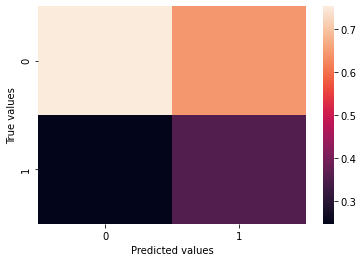

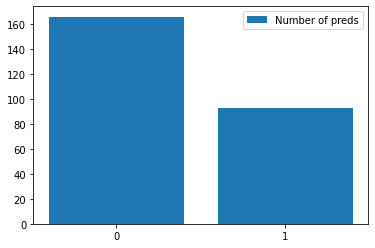

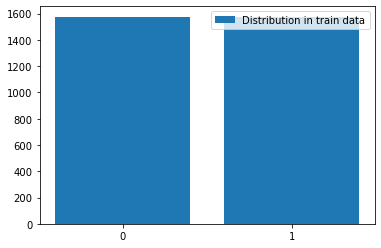

              precision    recall  f1-score   support

         0.0       0.75      0.68      0.71       185
         1.0       0.35      0.45      0.40        74

    accuracy                           0.61       259
   macro avg       0.55      0.56      0.55       259
weighted avg       0.64      0.61      0.62       259

12.5 %


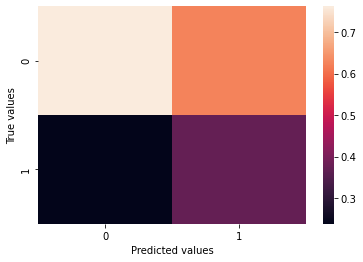

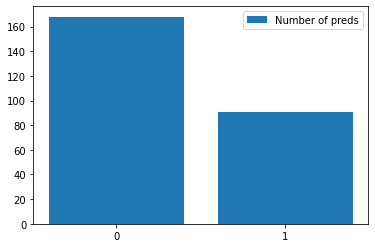

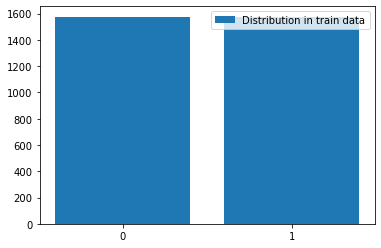

              precision    recall  f1-score   support

         0.0       0.76      0.69      0.73       185
         1.0       0.37      0.46      0.41        74

    accuracy                           0.63       259
   macro avg       0.57      0.58      0.57       259
weighted avg       0.65      0.63      0.64       259

25.0 %


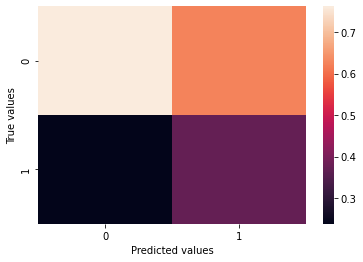

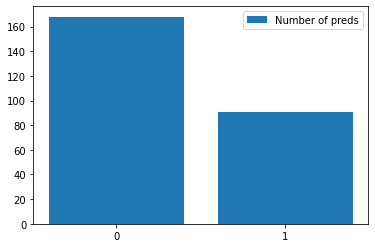

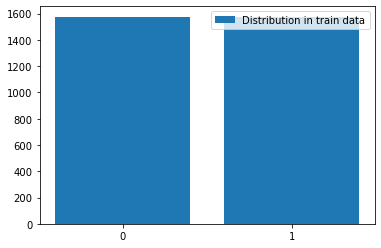

              precision    recall  f1-score   support

         0.0       0.76      0.69      0.73       185
         1.0       0.37      0.46      0.41        74

    accuracy                           0.63       259
   macro avg       0.57      0.58      0.57       259
weighted avg       0.65      0.63      0.64       259

37.5 %


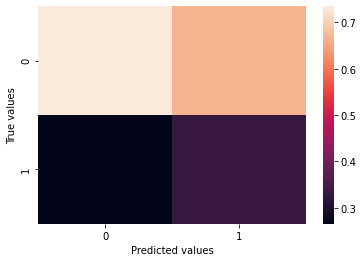

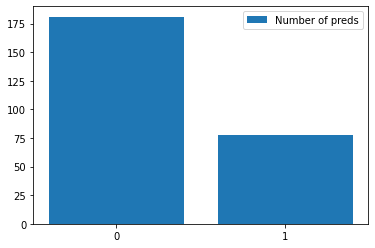

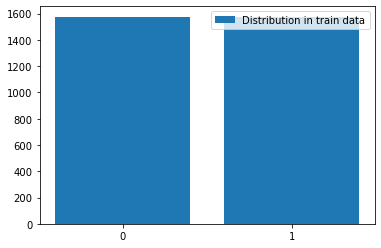

              precision    recall  f1-score   support

         0.0       0.73      0.72      0.73       185
         1.0       0.33      0.35      0.34        74

    accuracy                           0.61       259
   macro avg       0.53      0.54      0.53       259
weighted avg       0.62      0.61      0.62       259

50.0 %


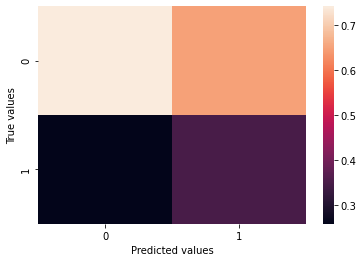

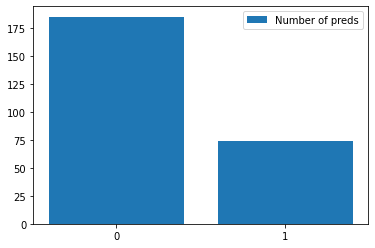

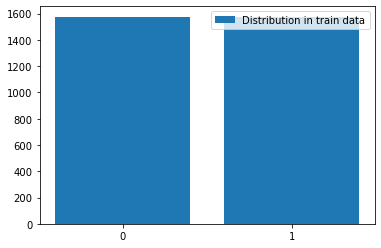

              precision    recall  f1-score   support

         0.0       0.74      0.74      0.74       185
         1.0       0.35      0.35      0.35        74

    accuracy                           0.63       259
   macro avg       0.55      0.55      0.55       259
weighted avg       0.63      0.63      0.63       259

62.5 %


KeyboardInterrupt: 

In [90]:
# XGBoost classifier
estimators = [50, 100, 500, 1000]
max_depth = [3,4]
n_configs = len(estimators) * len(max_depth)
ctr = 0
best_f1 = [f1, est]
for est in estimators: 
    for md in max_depth: 
        xgb_model = XGBClassifier(max_depth=md,n_estimators=est)
        xgb_model.fit(x_train,y_train)
        y_test_pred = xgb_model.predict(x_test)
        print_test_data(y_test, y_test_pred)
        if f1 > best_f1[0]: 
            best_f1 = [f1, est]
        ctr += 1
        print("{} %".format(round(100 * ctr / n_configs, 3)))
print("Best f1 score ({}) achieved with {} estimators.".format(best_f1[0], best_f1[1]))

In [ ]:
# LDA 
model_lda = LinearDiscriminantAnalysis()
model_lda.fit(x_train, y_train)
y_test_preds = model_lda.predict(x_test)
print_test_data(y_test, y_test_pred)